# Aggregating imported data across datasets

---

### package imports and basic functions

---

In [1]:
import os
import gc
import sys
import glob
import json
import random
import datetime
import importlib
import itertools
import numpy as np
from scipy import spatial
import scipy.sparse as sparse
import scipy.stats as stats
import pandas as pd
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import boto3


In [2]:
class MyNumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def ensure_dir(file_name):
    os.makedirs(os.path.dirname(file_name), exist_ok=True)
    return file_name


def list_dirs(path=os.getcwd()):
    files = glob.glob(os.path.join(path, '*'))
    files = [x for x in files if os.path.isdir(x)]
    return files


def file_exists(file_name, path_name=os.getcwd()):
    return os.path.isfile(os.path.join(path_name, file_name))


def write_json(json_obj, file_path):
    with open(file_path, 'w') as outfile:
        json.dump(json_obj, outfile, sort_keys=True, indent=4,
                  cls=MyNumpyEncoder)
    return json_obj


def load_json(file_path):
    with open(file_path, 'r') as infile:
        return json.load(infile)


def write_np(np_obj, file_path):
    with open(file_path, 'wb') as outfile:
        np.save(outfile, np_obj)


def load_np(file_path):
    with open(file_path, 'rb') as infile:
        return np.load(infile)


In [3]:
# path setting
main_dir = os.path.abspath('../../..')


## Load all imported data

---

In [4]:
# name of all imported datasets
datasets = [
    'HCP-YA',
    'HCP-D',
    'HCP-A',
]


In [5]:
valid_subjects = {
    dataset_name: load_json(f'{main_dir}/data/json/valid_subjects_{dataset_name}.json')
    for dataset_name in datasets
}


In [6]:
demographies = {
    dataset_name: pd.read_csv(f'{main_dir}/data/csv/demography_{dataset_name}.csv', index_col=0)
    for dataset_name in datasets
}
for dataset_name in datasets:
    # add dataset name to the beginning of subject IDs to ensure unique IDs
    demographies[dataset_name]['subject_ID'] = f'{dataset_name}-' + demographies[dataset_name]['subject_ID'].apply(str)
    
    # add constant site column if site information is not available
    if 'site' not in demographies[dataset_name]:
        demographies[dataset_name]['site'] = f'site_0'
        
    # add dataset name to the beginning of site information to ensure unique site IDs
    demographies[dataset_name]['site'] = f'{dataset_name}-' + demographies[dataset_name]['site'].apply(str)
    


In [7]:
thickness_data = {
    dataset_name: load_np(f'{main_dir}/data/npy/thickness_{dataset_name}.npy')
    for dataset_name in datasets
}


## Constructing group demography dataframe

---

In [8]:
demography_df = pd.concat([demographies[dataset_name] for dataset_name in datasets])

# encode site information
site_idxs, sites = pd.factorize(demography_df['site'])
demography_df['siteCode'] = site_idxs

demography_df.head()


,age,thickness,sex,subject_ID,dataset,site,siteCode
0,32.0,2.636395,1.0,HCP-YA-130518,HCP-YA,HCP-YA-site_0,0
1,35.0,2.633850,1.0,HCP-YA-192237,HCP-YA,HCP-YA-site_0,0
2,31.0,2.704905,1.0,HCP-YA-859671,HCP-YA,HCP-YA-site_0,0
3,33.0,2.629196,0.0,HCP-YA-158136,HCP-YA,HCP-YA-site_0,0
4,22.0,2.760889,0.0,HCP-YA-192136,HCP-YA,HCP-YA-site_0,0


In [9]:
demography_df.to_csv(ensure_dir(f'{main_dir}/data/csv/demography_all_datasets.csv'))


In [10]:
write_json(
    [f'{dataset_name}-{subject}' for dataset_name in datasets for subject in valid_subjects[dataset_name]],
    ensure_dir(f'{main_dir}/data/json/valid_subjects_all_datasets.json')
);


## Aggregating high-resolution thickness data

---

In [11]:
# all high-resolution thickness data
all_thickness_data = np.concatenate([thickness_data[dataset_name] for dataset_name in datasets])


In [12]:
all_thickness_data.shape

(2473, 59412)

In [13]:
write_np(all_thickness_data, ensure_dir(f'{main_dir}/data/npy/thickness_all_datasets.npy'));


## Group level visualizations

---

CPU times: user 82.6 ms, sys: 10.5 ms, total: 93.2 ms
Wall time: 78.3 ms


Text(0.5, 1.0, 'Age distributions across datasets')

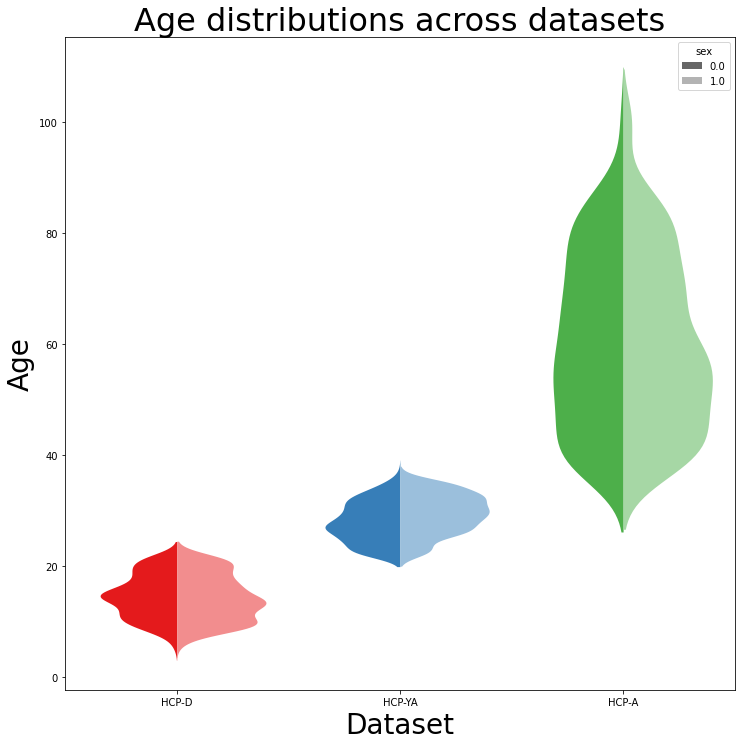

In [14]:
%%time

from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

data_order = demography_df.groupby(by=["dataset"])["age"].median().sort_values().index

sns.violinplot(
    data=demography_df,
    x='dataset',
    y='age',
    ax=ax,
    linewidth=0,
    hue='sex',
    palette=['.4', '.7'],
    alpha=0.5,
    split=True,
    scale="count",
    order=data_order,
)

colors = sns.color_palette('Set1')
for ind, violin in enumerate(ax.findobj(PolyCollection)):
    rgb = to_rgb(colors[ind // 2])
    if ind % 2 != 0:
        rgb = 0.5 + 0.5 * np.array(rgb)  # make whiter
    violin.set_facecolor(rgb)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Dataset', fontsize=28)
ax.set_ylabel('Age', fontsize=28)

ax.set_title('Age distributions across datasets', fontsize=32)


CPU times: user 160 ms, sys: 23.5 ms, total: 183 ms
Wall time: 141 ms


Text(0.5, 1.0, 'Mean thickness changes by age')

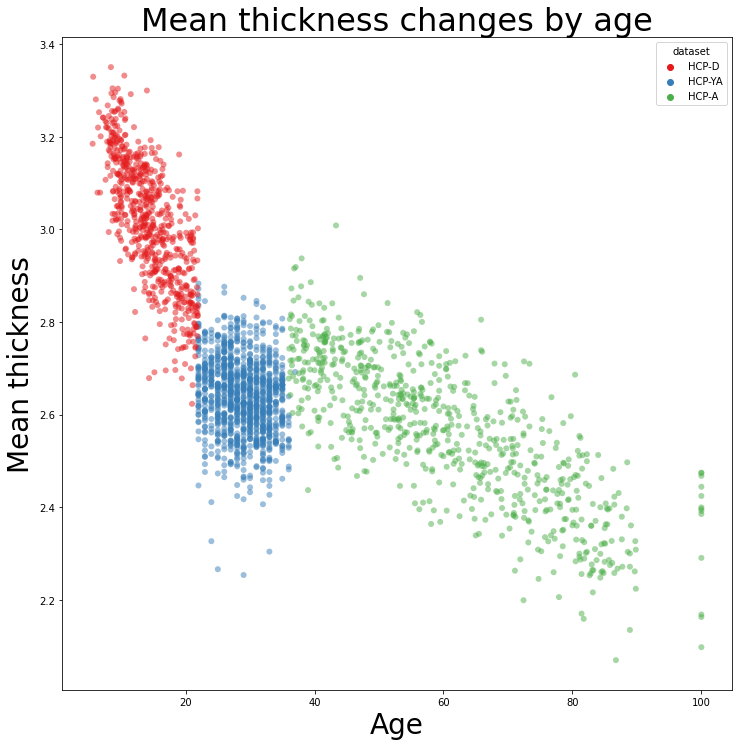

In [15]:
%%time

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

data_order = demography_df.groupby(by=["dataset"])["age"].median().sort_values().index

sns.scatterplot(
    data=demography_df,
    x='age',
    y='thickness',
    ax=ax,
    linewidth=0,
    hue='dataset',
    palette="Set1",
    alpha = 0.5,
    hue_order=data_order,
)

# ax.set_xlim(20,40)
# ax.set_ylim(2.2,3)

ax.set_xlabel('Age', fontsize=28)
ax.set_ylabel('Mean thickness', fontsize=28)

ax.set_title('Mean thickness changes by age', fontsize=32)
